<a href="https://colab.research.google.com/github/RajeshPeddireddy/VectorDB/blob/main/llamaIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://learn.deeplearning.ai/


https://learn.deeplearning.ai/building-evaluating-advanced-rag/lesson/3/rag-triad-of-metrics






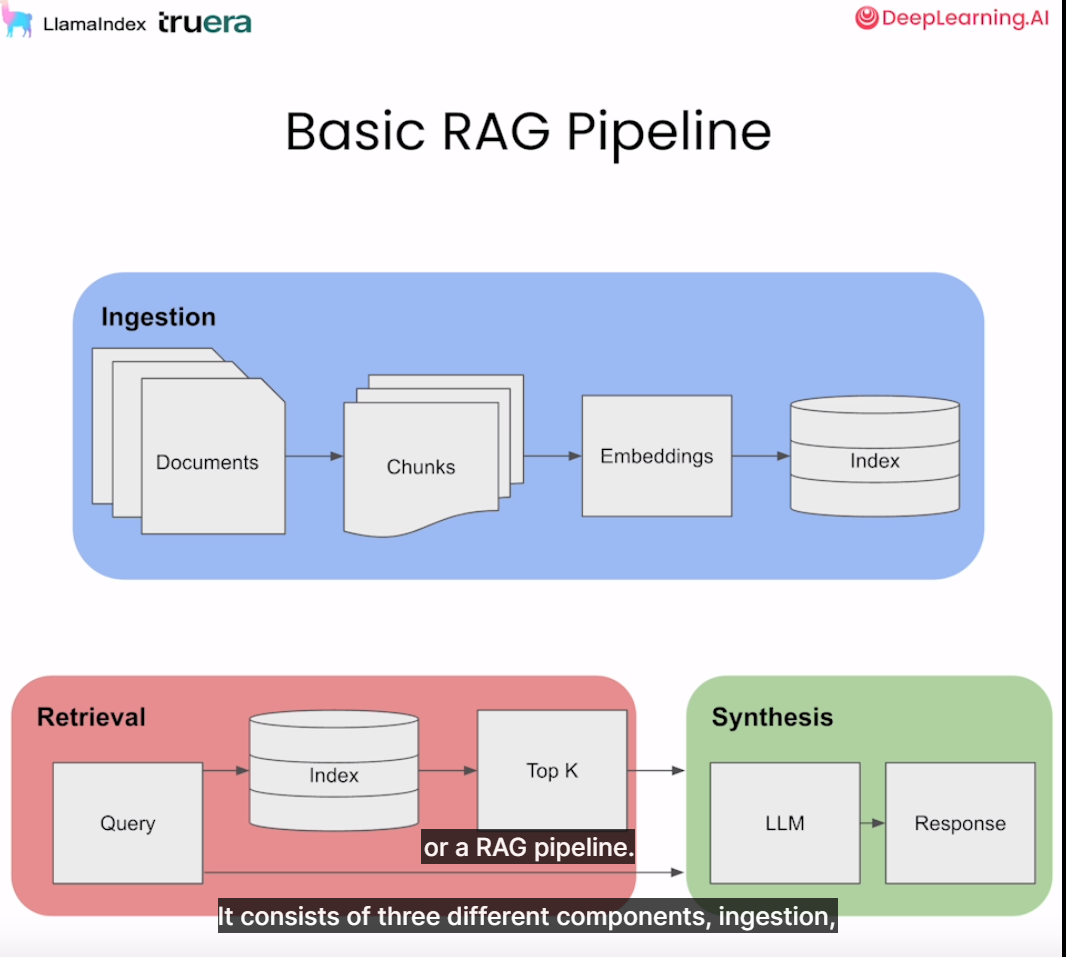

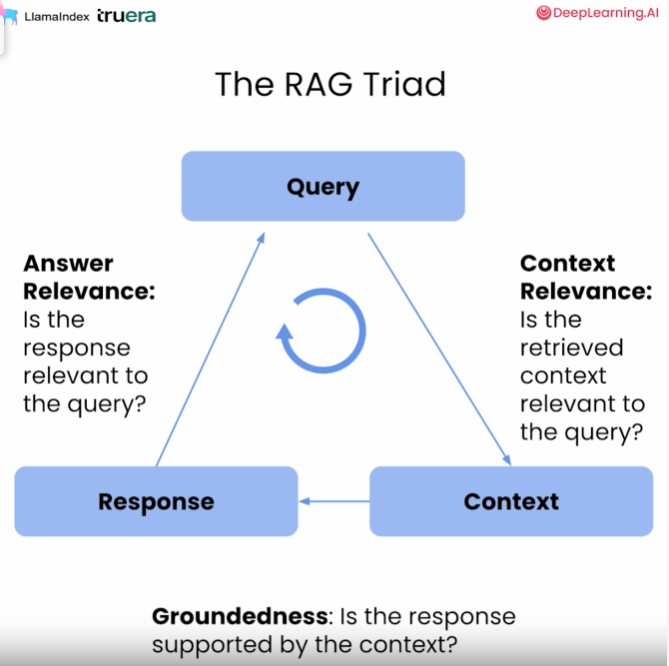

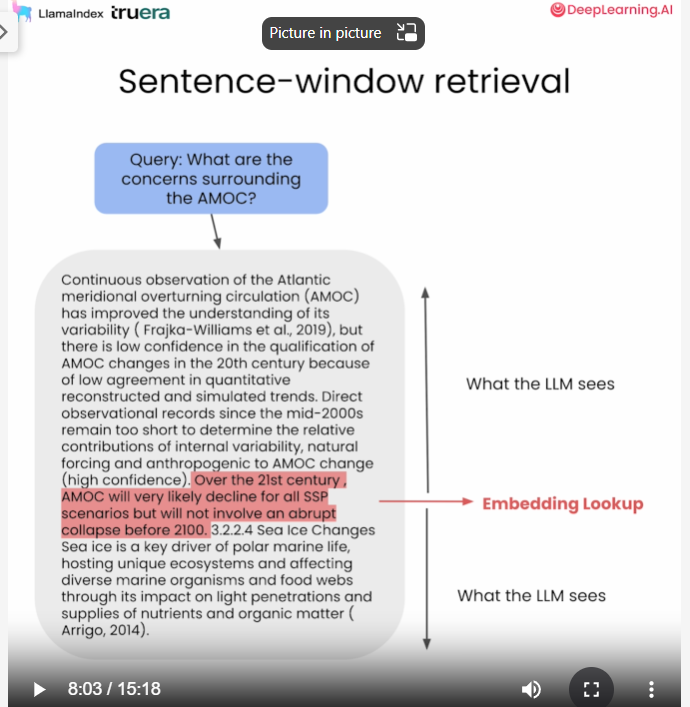

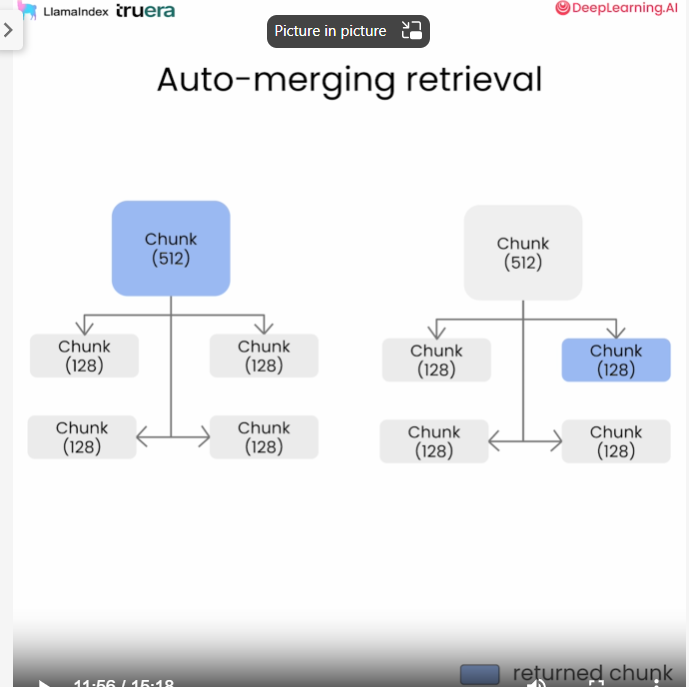

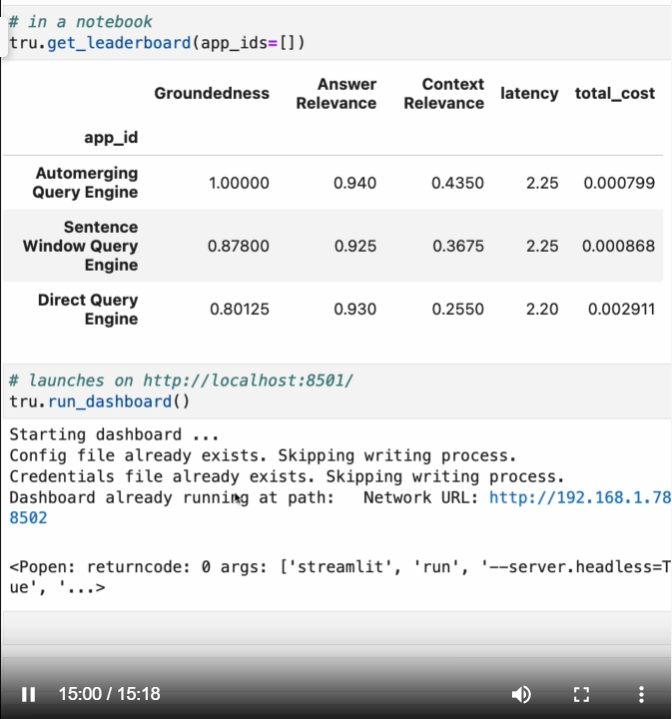